In [1]:
import pynsx as nsx
import math
import numpy as np
from matplotlib import pyplot as plt
from os import path

In [2]:
expt = nsx.Experiment('test', 'BioDiff2500')
diff = expt.getDiffractometer()
filename = path.expanduser("~/data/biodiff/p11202.hdf")
reader = nsx.HDF5DataReader(filename, diff)
data = nsx.DataSet(reader, diff)
expt.addData(data)

In [22]:
kernel = nsx.AnnularKernel(data.nRows(), data.nCols())
convolver = nsx.Convolver()
convolver.setKernel(kernel.matrix())

finder = nsx.PeakFinder()
finder.setConvolver(convolver)
finder.setMinComponents(30)
finder.setMaxComponents(10000)
finder.setIntegrationScale(3.0)
finder.setBackgroundScale(5.0)
finder.setSearchScale(1.0)
finder.setThresholdType(1)
finder.setThresholdValue(80.0)
finder.setKernel(kernel)

peaks = finder.find([data])
print(len(peaks))

9200


In [26]:
for peak in peaks:
    peak.setSelected(True)

In [27]:
# clean up peaks
good_peaks = []

for peak in peaks:
    I = peak.correctedIntensity().value()
    
    # keep only selected peaks
    if not peak.isSelected():
        continue
    
    # keep only strong peaks for autoindex
    if I < 1000.0:
        continue
        
    d = 1.0 / np.linalg.norm(peak.q().rowVector())
    
    # keep peaks only in specified d range
    if d > 40.0 or d < 1.8:
        continue
        
    good_peaks.append(peak)
    
print(len(good_peaks))

7403


In [28]:
indexer = nsx.AutoIndexer(nsx.ProgressHandler())

for peak in good_peaks:
    indexer.addPeak(peak)

print("auto indexing", len(good_peaks), "peaks")
        
params = nsx.IndexerParameters()
handler = nsx.ProgressHandler()
indexer.autoIndex(params)

soln = indexer.getSolutions()[0]
assert(soln[1] > 92.0)

uc = nsx.UnitCell(soln[0])
sample = diff.sample()
sample.addUnitCell(uc)

indexed_peaks = []

for peak in good_peaks:
    hkl = nsx.MillerIndex(peak.q(), uc)
    if np.linalg.norm(hkl.error()) < 0.2:
        peak.addUnitCell(uc, True)
        indexed_peaks.append(peak)
    
ch = uc.character()
print("indexed", len(indexed_peaks), "of", len(good_peaks))
print("found unit cell with parameters: ")
print("a: ", ch.a)
print("b: ", ch.b)
print("c: ", ch.c)
print("alpha: ", ch.alpha)
print("beta: ", ch.beta)
print("gamma: ", ch.gamma)

auto indexing 7403 peaks
indexed 7388 of 7403
found unit cell with parameters: 
a:  54.66609559712156
b:  58.42558511095634
c:  67.3880546039673
alpha:  1.5707963267948963
beta:  1.5707963267948966
gamma:  1.5707963267948963


In [7]:
nbatches = int(data.nFrames() / 5)
#nbatches = 1
states = data.instrumentStates()

refiner = nsx.Refiner(uc, indexed_peaks, nbatches)

refiner.refineSamplePosition(states)
refiner.refineKi(states)
refiner.refineSampleOrientation(states)
#refiner.refineU()
refiner.refineB()

success = refiner.refine(200)

print("refinement successful:", success)

refinement successful: True


In [355]:
from scipy.optimize import least_squares

def get_data(x0, y0, f0, radius, nframes):
    fit_data = []
    for peak in indexed_peaks:
        c = peak.getShape().center().reshape(3)
        x, y, f = c
        
        if (x-x0)**2 + (y-y0)**2 > radius**2:
            continue
            
        if abs(f-f0) > nframes:
            continue
            
        fit_data.append((peak, c.reshape(3), peak.getShape().inverseMetric()))
        
    return fit_data

def from_cholesky(p):
    L = np.array([[p[0]**2, 0, 0], [p[1],p[2]**2, 0], [p[3], p[4], p[5]**2]])
    return L.dot(L.transpose())


peak0 = random.sample(good_peaks,1)[0]
A0 = peak0.getShape().metric()
x0, y0, f0 = peak0.getShape().center().reshape(3)

fit_data = get_data(x0, y0, f0, 200, 20)
print(len(indexed_peaks))
print(len(fit_data))
assert(len(fit_data) > 50)

7388
153


In [308]:



def predict(p, dx):
    Ax = from_cholesky(p[0:6])
    Ay = from_cholesky(p[6:12])
    Az = from_cholesky(p[12:18])
    Aw = from_cholesky(p[18:24])
    #Ax = p[0:9].reshape(3,3)
    #Ay = p[9:18].reshape(3,3)
    #Az = p[18:27].reshape(3,3)
    #Aw = p[27:36].reshape(3,3)
    A = Ax*dx[0] + Ay*dx[1] + Az*dx[2] + Aw
    #A = 0.5 * (Aw + Aw.transpose())
    #A = 0.5 * (A + A.transpose())
    return A

def residual(p):
    x = np.array([x0, y0, f0])
    r = []
    
    for peak, center, A in fit_data:
        dx = center - x
        #dA = np.linalg.inv(A).dot(predict(p, dx)) - np.identity(3)
        dA = A - predict(p, dx)
        #print(dx)
        r.extend(dA.flatten() / len(fit_data))
        
    return r

mean_A = np.zeros((3,3), dtype=np.float)

for peak, c, A in fit_data:
    mean_A += A / len(fit_data)

#L = np.linalg.cholesky(mean_A)
p0 = 1e-1*np.random.rand(24)
#p0 = result.x
#p0 = np.zeros(24, dtype=np.float)
#p0[18:24] = np.sqrt(L[0,0]), L[1, 0], np.sqrt(L[1,1]), L[2,0], L[2,1], np.sqrt(L[2,2])
#p0 += np.random.rand(24)*0.05*np.linalg.norm(p0)
#p0 = np.random.rand(36)

#residual(p0)

result = least_squares(residual, p0, verbose=2, max_nfev=100, xtol=2.5e-16, gtol=2.5e-15, jac='cs')
#print(result.success)
print(result.x)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.9283e-01                                    1.58e+00    
       1              2         4.0965e-01      3.83e-01       2.26e-01       1.59e+00    
       2              4         3.7980e-01      2.99e-02       1.13e-01       1.28e-01    
       3              6         3.7827e-01      1.53e-03       5.65e-02       1.18e-02    
       4              8         3.7812e-01      1.47e-04       1.41e-02       5.52e-03    
       5              9         3.7803e-01      9.44e-05       1.41e-02       4.09e-03    
       6             10         3.7786e-01      1.65e-04       2.82e-02       5.26e-03    
       7             11         3.7745e-01      4.18e-04       5.65e-02       8.11e-03    
       8             13         3.7723e-01      2.17e-04       2.82e-02       9.41e-03    
       9             14         3.7698e-01      2.44e-04       2.82e-02       1.05e-02    

In [222]:
print(result.x)

[ 2.08362885e-02  5.44559973e-02  7.71206473e-02  6.45504637e-02
  7.90557648e-02  3.99804372e-02  9.20047225e-02  5.32106360e-02
  1.89891684e-02  1.77338078e-02  1.50986087e-02  8.51495715e-03
  1.47888025e-02  5.09212175e-02  1.33375373e-02  5.37108330e-03
  2.55245108e-02  3.16834720e-02 -6.33903288e-01  8.54417639e-02
  1.52927888e-04 -8.53697219e-01  2.44777644e+00  7.09713146e-02]


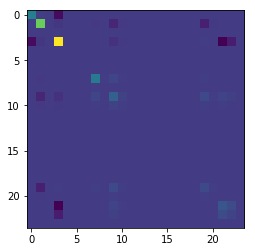

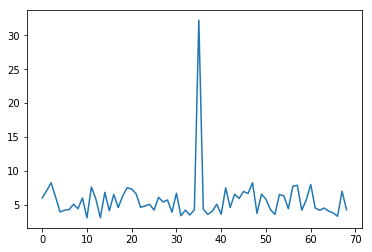

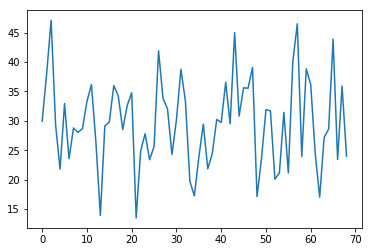

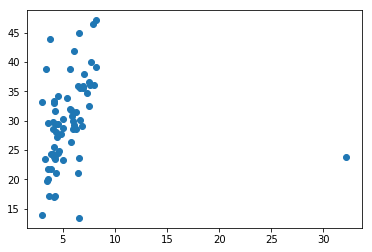

29.693706415844304 7.493152057686981


In [311]:
J = result.jac
JTJ = J.transpose().dot(J)
plt.imshow(JTJ)
plt.show()
#print(JTJ)

error = []
error2 = []


for peak, center, A in fit_data:
    A_pred = predict(result.x, peak.getShape().center().reshape(3))
    error.append(np.linalg.norm(A-A_pred))
    error2.append(np.linalg.norm(np.linalg.inv(A).dot(A_pred)-np.identity(3)))
    
    
plt.plot(error)
plt.show()

plt.plot(error2)
plt.show()

plt.scatter(error, error2)
plt.show()

print(np.mean(error2), np.std(error2))


7388
279
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7731e+04                                    2.13e+03    
       1              2         1.3940e+04      3.79e+03       1.36e+00       1.86e+03    
       2              3         7.9392e+03      6.00e+03       2.72e+00       1.31e+03    
       3              4         2.1931e+03      5.75e+03       5.44e+00       2.14e+02    
       4              5         2.0377e+03      1.55e+02       1.05e+00       8.27e-07    
       5              6         2.0377e+03      0.00e+00       0.00e+00       8.27e-07    
`xtol` termination condition is satisfied.
Function evaluations 6, initial cost 1.7731e+04, final cost 2.0377e+03, first-order optimality 8.27e-07.


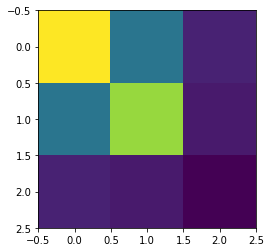

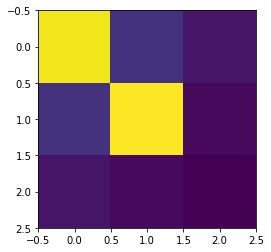

In [374]:
peak0 = random.sample(good_peaks,1)[0]
A0 = peak0.getShape().inverseMetric()
x0, y0, f0 = peak0.getShape().center().reshape(3)

fit_data = get_data(x0, y0, f0, 200, 20)
print(len(indexed_peaks))
print(len(fit_data))
assert(len(fit_data) > 50)

def predict(p):
    A = np.array([
        [p[0], p[1], p[2]],
        [p[1], p[3], p[4]],
        [p[2], p[4], p[5]]
    ])
    
    return A

def residual(p):
    A = predict(p)
    r = []
    
    for peak, center, A_obs in fit_data:
        #r.extend((np.linalg.inv(A_obs).dot(A)-np.identity(3)).flatten())
        r.extend((A_obs - A).flatten())
        
    return r

p = np.random.rand(6)
result = least_squares(residual, p, verbose=2)

plt.imshow(A0)
plt.show()

plt.imshow(predict(result.x))
plt.show()

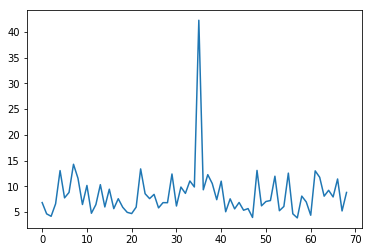

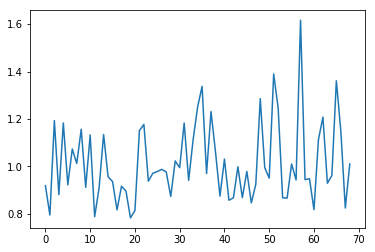

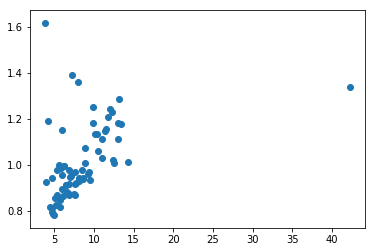

1.0138881258929453 0.16392919621450783


In [315]:
error = []
error2 = []
A_pred = predict(result.x)

for peak, center, A in fit_data:
    error.append(np.linalg.norm(A-A_pred))
    error2.append(np.linalg.norm(np.linalg.inv(A).dot(A_pred)-np.identity(3)))
    
    
plt.plot(error)
plt.show()

plt.plot(error2)
plt.show()

plt.scatter(error, error2)
plt.show()

print(np.mean(error2), np.std(error2))


700 300 50


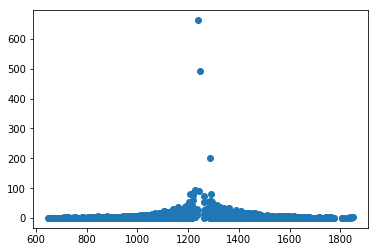

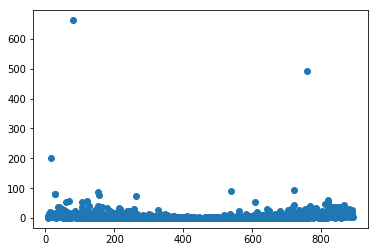

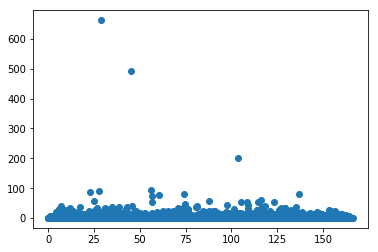

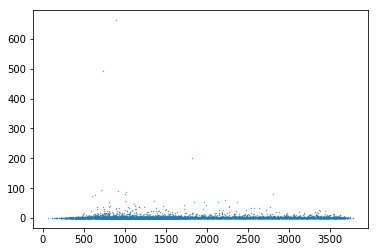

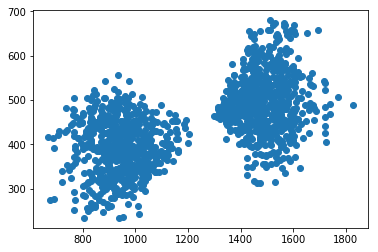

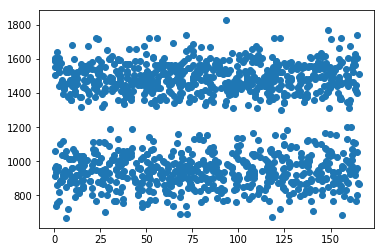

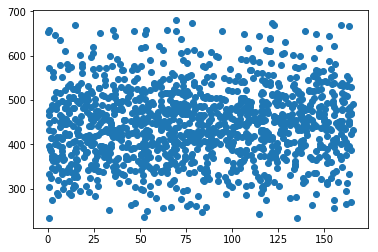

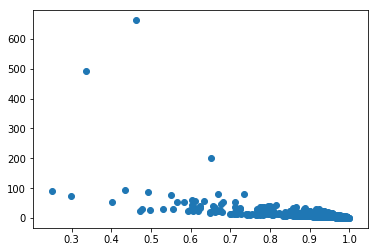

In [316]:
x = []
y = []
f = []
error = []
r = []
rho = []

good_x = []
good_y = []
good_f = []

print(x0, y0, f0)

A_pred = predict(result.x)

for peak in indexed_peaks:
    c = peak.getShape().center().reshape(3)
    
    r2 = (c[0]-x0)**2 + (c[1]-y0)**2 + 1000*(c[2]-f0)**2
    r.append(np.sqrt(r2))
    
    x.append(c[0])
    y.append(c[1])
    f.append(c[2])
    
    
    A = peak.getShape().metric()
    E = np.linalg.norm(np.linalg.inv(A).dot(A_pred)-np.identity(3))
    rho.append(A.transpose().dot(A_pred).trace() / np.linalg.norm(A) / np.linalg.norm(A_pred))
    error.append(E)
    
    if (E < 1.0):
        good_x.append(c[0])
        good_y.append(c[1])
        good_f.append(c[2])
    
plt.scatter(x, error)
plt.show()

plt.scatter(y, error)
plt.show()

plt.scatter(f, error)
plt.show()

plt.scatter(r, error, s=0.1)
plt.show()

plt.scatter(good_x, good_y)
plt.show()

plt.scatter(good_f, good_x)
plt.show()

plt.scatter(good_f, good_y)
plt.show()

plt.scatter(rho, error)
plt.show()

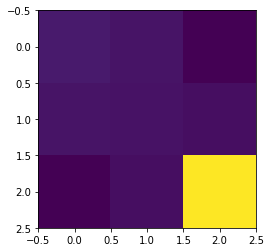

[0.38520978 2.58155829        nan]


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


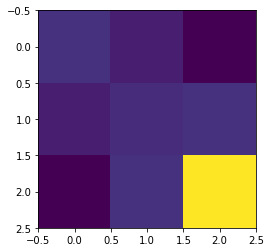

[0.55983215 2.54791007 2.98754284]


In [242]:
import random
peak, center, A = random.sample(fit_data, 1)[0]

A_pred = predict(result.x, center)

plt.imshow(A_pred)
plt.show()
print(1/np.sqrt(np.linalg.eig(A_pred)[0]))

plt.imshow(A)
plt.show()
print(1/np.sqrt(np.linalg.eig(A)[0]))

In [8]:
def find_batch(peak, batches):
    z = peak.getShape().center()[2,0]
    
    for b in batches:
        if b.contains(z):
            return b
        
    return None

def reindex(peak_list, batches):          
    new_peaks = []
    
    for peak in peak_list:
        
        batch = find_batch(peak, batches)
        
        if batch is None:
            continue
        
        hkl = np.array([[0.,0.,0.]])
        uc = batch.cell()
        
        if nsx.MillerIndex(peak.q(), uc).indexed(0.2):
            peak.addUnitCell(uc, True)
            new_peaks.append(peak)
            
    return new_peaks

refined_peaks = reindex(indexed_peaks, refiner.batches())

In [203]:
fit_data = []
standard_fit_data = []

#begin_frame = 50
#end_frame = begin_frame+5

begin_frame = 0
end_frame = begin_frame+400

class FitData:
    def __init__(self, peak):
        self.valid = False
        cov = peak.qShape().inverseMetric()
        cov = 0.5*(cov + cov.transpose())
        

        if np.isnan(np.linalg.norm(cov)):
            return

        C = np.linalg.cond(cov)    
        if np.isnan(C) or C > 1e4:
            return

        w, u = np.linalg.eig(cov)

        if min(w) < 0:
            return

        detector = peak.data().diffractometer().detector()
        center = peak.getShape().center()

        frame = center[2,0]

        if (frame < begin_frame):
            return
        
        if (frame > end_frame):
            return

        state = peak.data().interpolatedState(frame)

        Jd = state.jacobianQ(nsx.DetectorEvent(center))

        px = center[0,0]
        py = center[1,0]

        p = detector.pixelPosition(px, py).vector()
        p0 = state.samplePosition

        r = np.linalg.norm(p-p0)
        dp = p-p0

        Jp = -1/r*np.identity(3) + 1/r**3 * dp.dot(dp.transpose())

        rot = state.sampleOrientationMatrix()
        ki = state.ki().rowVector()
        qLab = peak.qPredicted().rowVector().dot(rot.transpose())
        kf = qLab + ki
        kf /= np.linalg.norm(kf)
        kf *= np.linalg.norm(ki)

        Jk = kf.transpose().dot(ki) / np.linalg.norm(ki)**2 - np.identity(3)

        q = qLab.reshape(3,1)
        #A = -2*q*q.transpose() / np.linalg.norm(q)**2

        axis = state.axis.reshape(3)
        qdot = np.cross(axis,q.reshape(3)).reshape(3,1) 
        
        self.peak = peak  
        self.det_icov = peak.getShape().metric()
        self.cov = cov
        self.R = rot.transpose()
        self.Jk = Jk
        self.Jp = Jp
        self.Jd = Jd
        self.ki = ki
        self.kf = kf
        self.q = kf-ki
        self.qdot = qdot
        self.stepsize = state.stepSize
        self.state = state
        self.axis = state.axis
        self.valid = True
        self.center = peak.getShape().center()
        
        
        A2 = self.det_icov[:2, :2]
        b2 = self.det_icov[:2,2]
        self.vdet = np.zeros((3,1), dtype=np.float)
        self.vdet[:2,0] = -np.linalg.inv(A2).dot(b2)
        self.vdet[2,0] = 1


for peak in refined_peaks:    
    ft = FitData(peak)
    
    if ft.valid:
        fit_data.append(ft)

print(len(fit_data))

3036


[-1.62120745 -2.02449557  0.61264108]
[ 1.75345009 -0.8546637   1.81581599]
[-2.29382987  2.23351143  1.31065309]


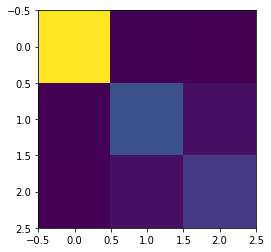

[[ 4.36593247e-05 -4.76529661e-06 -4.99217592e-06]
 [-4.76529661e-06  7.05561423e-06 -2.91218093e-06]
 [-4.99217592e-06 -2.91218093e-06  3.03274011e-06]]
[0.38339556 0.0394861  0.16700873]


In [204]:
import random
d, = random.sample(fit_data, 1)

q = d.peak.q().rowVector().reshape(3)
ki = d.R.dot(d.ki.reshape(3))
kf = q + ki
#print(q)
#print(kf-ki)

e1 = np.cross(kf, ki)
e2 = np.cross(kf, e1)
e3 = kf+ki
#e3 = d.R.dot(d.qdot.reshape(3))

e1 /= np.linalg.norm(e1) * np.linalg.norm(kf)
e2 /= np.linalg.norm(e2) * np.linalg.norm(kf)
e3 /= np.linalg.norm(e3) * np.linalg.norm(q)

J = d.state.jacobianQ(nsx.DetectorEvent(d.peak.getShape().center()))
J[:,2] -= d.R.dot(d.qdot.reshape(3))*d.stepsize
JI = np.linalg.inv(J)

A = peak.getShape().metric()
A = JI.transpose().dot(A).dot(JI)

L = np.array([e1, e2, e3])
print(e1)
print(e2)
print(e3)

LI = np.linalg.inv(L)

A = LI.transpose().dot(A).dot(LI)

AI = np.linalg.inv(A)

plt.imshow(AI)
plt.show()

print(AI)
print(np.sqrt(np.linalg.eig(AI)[0])*180.0 / np.pi)

vdet: [[0.02485471 1.87905849 1.        ]]
axis [[ 2.56879067e-04  8.48272622e-02 -9.96395639e-01]]
qdot [[-0.06273032 -0.06306041 -0.00538477]]
last col J: [0.06642053 0.071062   0.00736213]
kf J: [[-1.38896709e-08 -1.19044049e-07  2.23816830e-04]]
ki: [[-9.78577019e-04  3.75233218e-01  1.44500847e-04]]
kf: [[0.06221693 0.29285712 0.22619618]]
q: [[ 0.0631955  -0.0823761   0.22605168]]
v: [[ 4.35886685e-04 -6.97963274e-05  9.58962343e-04]]
w: [[-5.27649143e-04 -5.30425726e-04 -4.52933578e-05]]
|v| 0.0010556881666831223
|w| 0.0007495442327328049
Dw [[-0.0420799   0.02009699 -0.88648844]]


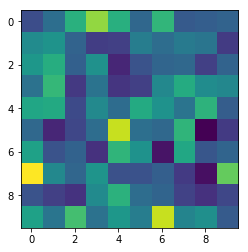

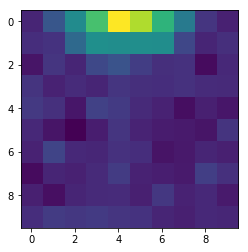

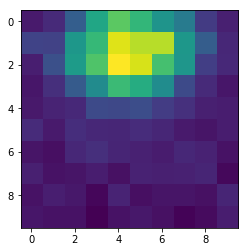

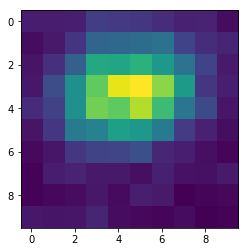

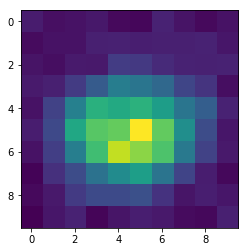

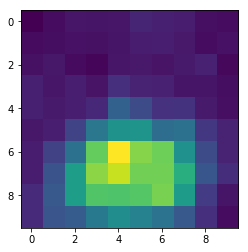

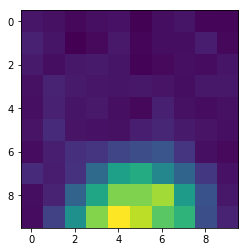

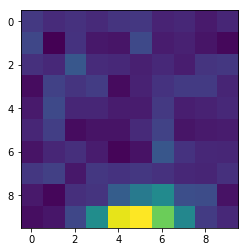

In [205]:
import random
d, = random.sample(fit_data, 1)

kf = d.kf
ki = d.ki
R = d.R
q = kf-ki
Jd = d.Jd

d.vdet


print("vdet:", d.vdet.transpose())

w = d.qdot * d.state.stepSize

v = d.R.transpose().dot(d.Jd.dot(d.vdet))

#print(kf.dot(R.transpose().dot(Jd)))

#print(kf)

print("axis", d.state.axis.transpose())
print("qdot", d.qdot.transpose())
print("last col J:", (R.transpose().dot(Jd))[:,2].transpose()/d.state.stepSize)
print("kf J:", kf.dot(R.transpose().dot(Jd)))

print("ki:", ki)
print("kf:", kf)
print("q:", q)

print("v:", v.transpose())
print("w:", w.transpose())

print("|v|", np.linalg.norm(v))
print("|w|", np.linalg.norm(w))

Rw = R.dot(w)
Dw = np.linalg.inv(Jd).dot(Rw)

print("Dw", Dw.transpose())

if True:
    for z in range(int(d.center[2,0]-4), int(d.center[2,0]+4)):
        y = int(round(d.center[1,0]))
        x = int(round(d.center[0,0]))
        image = data.frame(z)[y-5:y+5, x-5:x+5]
        plt.imshow(image)
        plt.show()


In [206]:
from scipy.optimize import least_squares

def new_predict(d, x):
    deg = np.pi / 180    
    
    sigmaD = x[0:9].reshape(3,3)
    sigmaM = x[9:18].reshape(3,3)
    sigmaS = x[18:27].reshape(3,3)
    
    v = d.qdot.reshape(3,1)
    
    R = d.R
    kf = d.kf.reshape(3,1)
    ki = d.ki.reshape(3,1)  
    q = kf-ki
    n = q / np.linalg.norm(q)
    
    nnt = n.dot(n.transpose())
    nkt = n.dot(ki.transpose())
    nk = nkt.trace()
    
    I = np.identity(3)
    NK = nk*I + nkt   
    
    Jp = d.Jp
    
    Sig = np.zeros((3,3), dtype=np.float)
    
    # mosaicity term
    Pq = np.identity(3) - q.dot(q.transpose()) / np.linalg.norm(q)**2
    Sig += np.linalg.norm(q)**2 * Pq.dot(sigmaM.dot(sigmaM.transpose())).dot(Pq.transpose())
        
    # beam divergence term
    A = np.identity(3) - kf.dot(ki.transpose()) / np.linalg.norm(ki)**2
    Sig += A.dot(sigmaD.dot(sigmaD.transpose())).dot(A.transpose())
    
    # crystal shape in beam
    Jp = d.Jp
    Sig += Jp.dot(sigmaS.dot(sigmaS.transpose())).dot(Jp.transpose())
            
    pred = R.dot(Sig).dot(R.transpose())
    
    return pred


#new_predict(random.sample(fit_data, 1)[0], result.x)

In [207]:
def new_residual(x):
    r = []
    
    for d in fit_data:
        pred = new_predict(d, x)     
        #r.extend((icov-pred).flatten())
        r.extend((d.cov-pred).flatten())
    
    return r

#x0 =   1.52786047e-03,  4.46037216e-05, 3.46386731e-04, -2.95699391e-05, 1.73883536e-05, 1e-5
x0 = 1e-3 * np.random.rand(27)
#x0.append(1e-3)
#x0.append(1e-3)

#result = least_squares(new_residual, [sigmaD, sigmaM, sigma0])
result = least_squares(new_residual, x0, max_nfev=20, verbose=2)

print(result)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.9115e-06                                    4.50e-03    
       1              2         3.7697e-07      2.53e-06       3.41e-03       1.34e-03    
       2              3         6.9471e-08      3.07e-07       6.81e-03       3.38e-04    
       3              5         1.3620e-08      5.59e-08       3.41e-03       4.39e-05    
       4              7         1.1657e-08      1.96e-09       1.70e-03       5.89e-06    
       5              9         1.1598e-08      5.90e-11       8.51e-04       1.10e-06    
       6             11         1.1587e-08      1.10e-11       2.13e-04       9.03e-08    
       7             12         1.1586e-08      1.59e-12       2.13e-04       8.70e-08    
       8             14         1.1585e-08      8.12e-13       5.32e-05       5.54e-09    
`gtol` termination condition is satisfied.
Function evaluations 14, initial cost 2.9115e-0

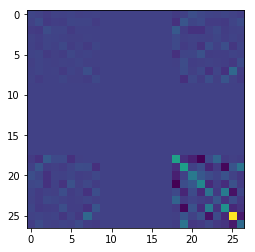

0 1 0.20650638563303556
0 2 -0.6425433173513028
0 3 0.14515750176763498
0 4 -0.12735863058317437
0 5 0.3055663433743581
0 6 -0.24444061352005123
0 7 -0.08872521183211418
0 8 0.21089430725603764
0 9 -0.06398360967650885
0 10 -0.031940226366846694
0 11 0.08872130047983469
0 12 -0.16283132922832852
0 13 0.042111526835063154
0 14 0.13970865356612738
0 15 0.22780741279281977
0 16 -0.04246861848190107
0 17 -0.2273056326496229
0 18 -0.26899864328333556
0 19 -0.016990371724968936
0 20 0.7783368938329052
0 21 0.25870013693852306
0 22 0.1413134839014182
0 23 0.05693141665768058
0 24 0.19161252861193673
0 25 0.008179914014890266
0 26 -0.16827565737449976
1 2 -0.6639357425954437
1 3 -0.551119417979462
1 4 -0.4336320959375669
1 5 0.6008036617611362
1 6 0.6396538786417545
1 7 0.23935210740945637
1 8 -0.5699972302623947
1 9 0.19255126892875668
1 10 0.13860847160534734
1 11 -0.11373741901472394
1 12 -0.029696020605300022
1 13 0.03130350133298272
1 14 0.03470657047584201
1 15 0.04690129159176699
1 16 0

In [354]:
J = result.jac
JTJ = J.transpose().dot(J)
plt.imshow(JTJ)
plt.show()
#####
JTJ

m, n = JTJ.shape

for i in range(m):
    for j in range(i+1, n):
        print(i, j, JTJ[i,j] / np.sqrt(JTJ[i,i]) / np.sqrt(JTJ[j,j]))
        
w, u = np.linalg.eig(JTJ)
print(w)
u0 = u[:, np.argmax(w)]
print(np.linalg.norm(u0))
print(u[:, np.argmax(w)])


mean pearson: 0.9909995732600203


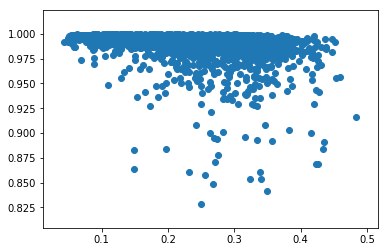

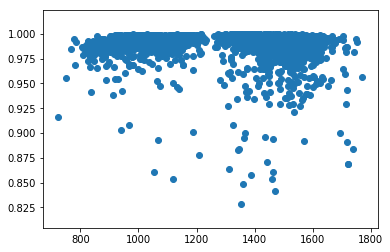

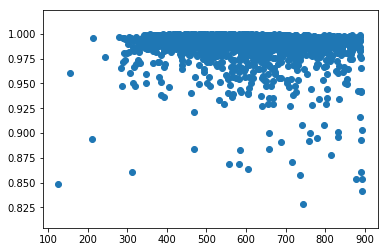

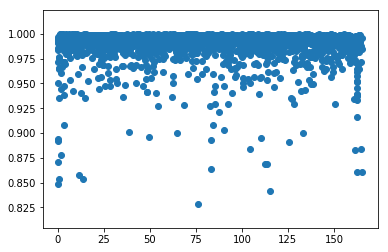

In [355]:
def pearson(a,b):
    return a.transpose().dot(b).trace() / np.linalg.norm(a) / np.linalg.norm(b)

qs = []
xs = []
ys = []
zs = []
pearsons = []

for d in fit_data:
    obs = d.cov
    pred = new_predict(d, result.x)
    qs.append(np.linalg.norm(d.kf-d.ki))
    pearsons.append(pearson(obs,pred))
    xs.append(d.center[0,0])
    ys.append(d.center[1,0])
    zs.append(d.center[2,0])
    
print("mean pearson:", sum(pearsons)/len(pearsons))
    
plt.scatter(qs, pearsons)
plt.show()

plt.scatter(xs, pearsons)
plt.show()

plt.scatter(ys, pearsons)
plt.show()

plt.scatter(zs, pearsons)
plt.show()


mean pearson: 0.9287788951840595


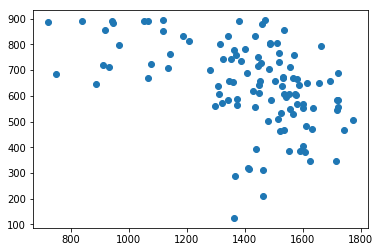

In [356]:

qs = []
xs = []
ys = []
zs = []
pearsons = []

for d in fit_data:
    obs = d.cov
    pred = new_predict(d, result.x)
    rho = pearson(obs,pred)
    
    if (rho > 0.96):
        continue
    
    qs.append(np.linalg.norm(d.kf-d.ki))
    pearsons.append(pearson(obs,pred))
    xs.append(d.center[0,0])
    ys.append(d.center[1,0])
    zs.append(d.center[2,0])
    
print("mean pearson:", sum(pearsons)/len(pearsons))
    
plt.scatter(xs, ys)
plt.show()


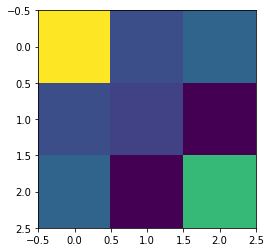

[6.49108768e-06 2.87444112e-06 5.14030471e-07]


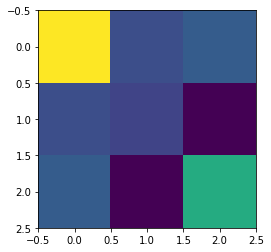

[7.25921534e-06 3.23721767e-06 6.10628100e-07]


In [382]:

import random
d= random.sample(fit_data, 1)[0]

obs = d.cov
plt.imshow(obs)
plt.show()
w, _ = np.linalg.eig(obs)
print(w)

pred = new_predict(d, result.x)
plt.imshow(pred)
plt.show()
w, _ = np.linalg.eig(pred)
print(w)

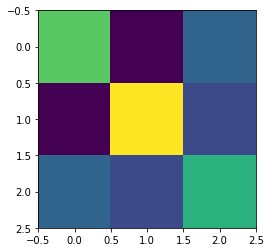

[[ 1.78980670e-06 -1.35847346e-06  1.18390100e-08]
 [-1.35847346e-06  2.88129458e-06 -4.11489360e-07]
 [ 1.18390100e-08 -4.11489360e-07  1.35590727e-06]]


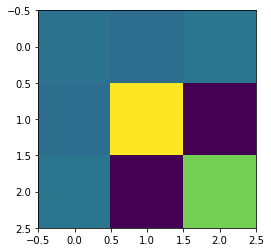

[[ 5.26983771e-12 -1.12378700e-10  7.70028995e-11]
 [-1.12378700e-10  3.49225284e-09 -2.14627168e-09]
 [ 7.70028995e-11 -2.14627168e-09  2.32235971e-09]]


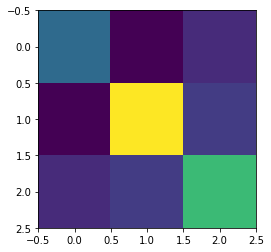

[[ 4.67142129e-08 -1.30057800e-08  7.96731515e-09]
 [-1.30057800e-08  1.59654015e-07  1.76651181e-08]
 [ 7.96731515e-09  1.76651181e-08  1.04641714e-07]]


In [375]:
sigmaD = result.x[:9].reshape(3,3)
sigmaD = sigmaD.dot(sigmaD.transpose())

plt.imshow(sigmaD)
plt.show()
print(sigmaD)

sigmaM = result.x[9:18].reshape(3,3)
sigmaM = sigmaM.dot(sigmaM.transpose())

plt.imshow(sigmaM)
plt.show()
print(sigmaM)

sigmaS = result.x[18:27].reshape(3,3)
sigmaS = sigmaS.dot(sigmaS.transpose())

plt.imshow(sigmaS)
plt.show()
print(sigmaS)

In [92]:
d = random.sample(fit_data, 1)[0]

J = d.Jd
JI = np.linalg.inv(J)
R = d.R.transpose()

A = JI.transpose().dot(d.det_icov).dot(JI)
A = R.dot(A).dot(R.transpose())

#e1 = np.cross(d.kf, d.ki)
#e2 = np.cross(d.kf, e1)

#e1 /= np.linalg.norm(e1) / np.linalg.norm(d.kf)
#e2 /= np.linalg.norm(e2) / np.linalg.norm(d.kf)
L = abs(d.qdot.dot(d.kf).trace() / np.linalg.norm(d.qdot) / np.linalg.norm(d.kf))
#e3 = d.qdot * np.linalg.norm(d.q) / np.linalg.norm(d.qdot)
#e3 = np.cross(d.q, e1)

e1 = np.cross(d.kf.reshape(3), d.qdot.reshape(3))
e2 = np.cross(d.kf, e1)
e1 /= np.linalg.norm(e1)
e2 /= np.linalg.norm(e2)

e3 = d.qdot / np.linalg.norm(q) #/ np.linalg.norm(d.qdot)#/ (np.linalg.norm(d.q) * L)
#e3 = np.cross(d.q, e1) / np.linalg.norm(q)

B = np.array([e1.reshape(3), e2.reshape(3), e3.reshape(3)]).transpose()
#BI = np.linalg.inv(B)
BT = B.transpose()

A = BT.dot(A).dot(B)

w, u = np.linalg.eig(np.linalg.inv(A))
#print(w)
print(np.sqrt(w) / np.pi * 180)
print(u)

plt.imshow(A)
plt.show()

NameError: name 'q' is not defined

In [925]:
L

0.9679746530503546

In [126]:
from scipy.optimize import least_squares

class ShapeModel:
    def __init__(self):
        # crystal mosaicity
        self.mos = np.zeros((3,3), dtype=np.float)
        # beam divergence
        self.div = np.zeros((3,3), dtype=np.float)
        # crystal shape
        self.shape = np.zeros((3,3), dtype=np.float)
        # cross term between scattering point and divergence
        self.div_cross = np.zeros((3,3), dtype=np.float)
        # detector bleeding
        self.bleed = np.zeros((3,3), dtype=np.float)
        # cross term mosaicity and scattering point
        self.mos_cross = np.zeros((3,3), dtype=np.float)
        
    def encode(self):
        return np.concatenate(
            [self.mos.flatten(), 
            self.div.flatten(), 
            self.shape.flatten()])#,             
            #self.div_cross.flatten(),           
            #self.bleed.flatten(),
            #self.mos_cross.flatten()])
        #])
    
    def decode(self, x):
        sym = lambda x: 0.5*(x+x.transpose())
        self.mos = x[:9].reshape(3,3)
        self.div = x[9:18].reshape(3,3)
        self.shape = x[18:27].reshape(3,3)
        #self.div_cross = x[27:36].reshape(3,3)
        #self.bleed = sym(x[36:45].reshape(3,3))
        #self.mos_cross = sym(x[45:].reshape(3,3))
            
        #self.mos = x[0]
        #self.div = x[1]
        #self.shape = sym(x[2:11].reshape(3,3))
        #self.cov = x[11:20].reshape(3,3)
        
    def scatter_cov(self):
        big_cov = np.zeros((9,9), dtype=np.float)
        big_cov[:3, :3] = self.mos
        big_cov[3:6, 3:6] = self.div
        big_cov[6:9, 6:9] = self.shape
        
        big_cov[:3, 3:6] = self.mos_cross
        big_cov[3:6, :3] = self.mos_cross.transpose()
        
        big_cov[3:6, 6:9] = self.div_cross
        big_cov[6:9, 3:6] = self.div_cross.transpose()
        
        return big_cov
            
        
    def predict(self, data):
        q = data.kf-data.ki      
        kf = data.kf  
       
        R = data.R
        Pq = np.identity(3) - q.dot(q.transpose()) / np.linalg.norm(q)**2
        Pk = np.identity(3) - kf.dot(kf.transpose()) / np.linalg.norm(kf)**2
                
        M = self.mos.dot(self.mos.transpose())
        M = R.transpose().dot(M).dot(R)
        
        cov = np.linalg.norm(q)**2 * Pq.dot(M).dot(Pq)
        
        B = self.div.dot(self.div.transpose())
        cov += np.linalg.norm(kf)**2 * Pk.dot(B).dot(Pk)
        
        S = self.shape.dot(self.shape.transpose())
        cov += Pk.dot(S).dot(Pk)
                
        return R.dot(cov).dot(R.transpose())
    
    def residual(x, fit_data):
        m = ShapeModel()
        m.decode(x)
        
        res = []

        for dt in fit_data:
            pred_cov = m.predict(dt)
            obs_cov = dt.cov
            #diff = np.linalg.inv(S)-np.linalg.inv(Sfit)
            diff = obs_cov-pred_cov
            res.extend(diff.flatten())
            #res.append(KL_divergence(S, Sfit))

        return res
    
    def summarize(self):
        print("Mosaicity")
        plt.imshow(self.mos)
        plt.show()
        w, _ = np.linalg.eig(self.mos)
        print(w)

def KL_divergence(S0, S1):
    k, _ = S0.shape    
    A = np.linalg.inv(S1).dot(S0)    
    return 0.5 * (A.trace() - k - np.log(np.linalg.det(A)))


#model = ShapeModel()
#model.mos = 0.01 * np.identity(3)
#model.div = 0.3 * np.identity(3)
#model.div[1,1] = 0.001
#model.shape = 0.01 * np.identity(3)

result = least_squares(lambda x: ShapeModel.residual(x, fit_data), model.encode(), gtol=3e-16, verbose=2,max_nfev=10)
print(result)

model.decode(result.x)

#model.summarize()
#print(model.bleed)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.2322e-08                                    1.66e-08    
       1              6         3.2321e-08      3.25e-13       2.92e-05       4.66e-09    
       2              8         3.2321e-08      7.40e-14       1.46e-05       2.10e-09    
       3             10         3.2321e-08      1.86e-14       7.30e-06       1.08e-09    
The maximum number of function evaluations is exceeded.
Function evaluations 10, initial cost 3.2322e-08, final cost 3.2321e-08, first-order optimality 1.08e-09.
 active_mask: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
        cost: 3.232115275759742e-08
         fun: array([-2.41522405e-06,  2.13403853e-07,  3.44629804e-08, ...,
       -1.07698496e-06,  6.60033184e-07, -2.62704066e-07])
        grad: array([-1.84256001e-10, -2.84449899e-11, -1.43366076e-10, -9

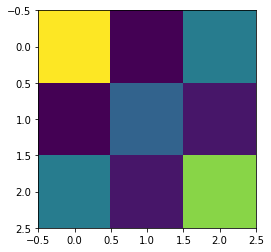

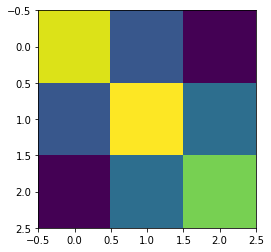

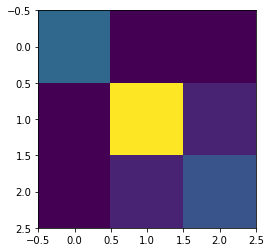

In [127]:
print_eig = lambda x: print(np.linalg.eig(x)[0])

M = model.mos
M = M.dot(M.transpose())

D = model.div
D = D.dot(D.transpose())

S = model.shape
S = S.dot(S.transpose())

plt.imshow(M)
plt.show()

plt.imshow(D)
plt.show()

plt.imshow(S)
plt.show()

In [120]:
np.linalg.eig(D)[1]

array([[ 0.55556853,  0.73189715,  0.3945506 ],
       [ 0.62988681, -0.06072013, -0.77430981],
       [ 0.54275798, -0.67870437,  0.49474655]])

In [184]:
import random
dt = random.sample(fit_data, 1)[0]

plt.imshow(S)
plt.show()

Sfit = model.predict(dt)

plt.imshow(Sfit)
plt.show()

w_obs, u_obs = np.linalg.eig(S)
w_fit, u_fit = np.linalg.eig(Sfit)

print(w_obs)
print(w_fit)


print(S.transpose().dot(Sfit).trace() / np.linalg.norm(S) / np.linalg.norm(Sfit))

NameError: name 'S' is not defined

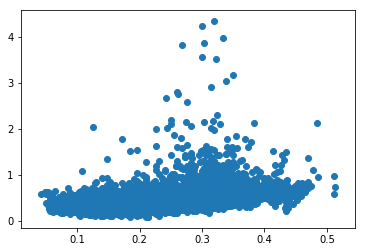

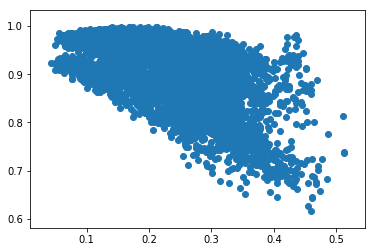

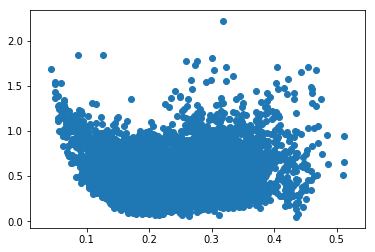

NameError: name 'good_fit_data' is not defined

In [125]:
errors = []
KL_errors = []
pearson = []
qs = []

#good_fit_data = fit_data

new_fit_data = []

for dt in fit_data:
    pred = model.predict(dt)
    
    #err = np.linalg.norm(S-Sfit)
    err = np.linalg.norm(pred-dt.cov) /np.linalg.norm(dt.cov)
    
    if (err > 1e10):
        continue
    
    errors.append(err)
    KL_errors.append(KL_divergence(dt.cov, pred))
    pearson.append(dt.cov.transpose().dot(pred).trace() / np.linalg.norm(pred) / np.linalg.norm(dt.cov))
    qs.append(np.linalg.norm(dt.q))
    
    if (pearson[-1] > 0.95):
        new_fit_data.append(dt)
    
    
qs = np.array(qs)

plt.scatter(qs, errors)
plt.show()

plt.scatter(qs, pearson)
plt.show()

plt.scatter(qs, KL_errors)
plt.show()

pearson = np.array(pearson)
pmean = pearson.mean()
pstd = pearson.std()

print("number of good peaks:", len(good_fit_data))
print("mean pearson:", pmean)
print("mean error:", sum(errors)/len(errors))

result = least_squares(lambda x: ShapeModel.residual(x, new_fit_data), model.encode(), gtol=3e-16)
#print(result)

model.decode(result.x)


print_eig(model.mos)
print_eig(model.div)
print_eig(model.shape)
print_eig(model.bleed)
print_eig(model.scatter_cov())


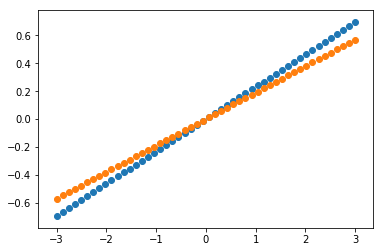

In [307]:
def ellipse_center(cov, z):
    A = np.linalg.inv(cov)
    b = A[:2,2]
    c = A[2,2]
    A2 = A[:2,:2]
    
    r2 = 1 - c*z**2 + b.transpose().dot(A2.dot(b))
    center = -np.linalg.inv(A2).dot(b)*z
    
    return center
    
    
dt = random.sample(fit_data, 1)[0]
pred_cov = model.predict(dt)
obs_cov = dt.cov

# to detector space
JI = np.linalg.inv(dt.Jd)
pred_cov = JI.dot(pred_cov).dot(JI.transpose())
obs_cov = JI.dot(obs_cov).dot(JI.transpose())

zs = np.linspace(-3, 3)

obs_xs = []
obs_ys = []

pred_xs = []
pred_ys = []

dx = []
dy = []

dc = []

for z in zs:
    c_obs = ellipse_center(obs_cov, z)
    c_pred = ellipse_center(pred_cov, z)
    
    pred_xs.append(c_pred[0])
    pred_ys.append(c_pred[1])
    
    obs_xs.append(c_obs[0])
    obs_ys.append(c_obs[1])
    
    dx.append(c_obs[0]-c_pred[0])
    dy.append(c_obs[1]-c_pred[1])
        
    dc.append(np.linalg.norm(np.array(c_obs)-np.array(c_pred)))
    
    
#plt.scatter(zs, pred_xs)
#plt.show()

#plt.scatter(obs_ys, pred_ys)
#plt.show()

plt.scatter(zs, dx)
plt.scatter(zs, dy)
plt.show()


In [ ]:
Mos, Beam, Shape, Det = decode(result.x)

w, u = np.linalg.eig(Beam)
print(np.sqrt(w) / 2.67 / np.pi * 180)
print(u)

In [ ]:
errors = []
mean = np.zeros((3,3), dtype=np.float)

good_fit_data = fit_data

for S, R, A in fit_data:
    mean += S
    
mean /= len(fit_data)

for S, R, A in fit_data:
    errors.append(np.linalg.norm(S-mean) / np.linalg.norm(S))
    
plt.plot(range(len(errors)), errors)
plt.show()

errors = np.array(errors)
print(errors.mean())
print(errors.std())

new_fit_data = []

for i in range(len(fit_data)):
    if errors[i] > errors.mean() + 3*errors.std():
        print(i, (errors[i]-errors.mean()) / errors.std())
    else:
        good_fit_data.append(fit_data[i])
               


In [ ]:
def mean_DKL(M, D, data):
    DKLs = [ DKL(S, fit_model(M, D, R, A)) for S, R, A in data]
    return np.array(DKLs).mean()

def DKL(S1, S2):
    d = 0    
    d = np.log(np.linalg.det(S2) / np.linalg.det(S1))
    d += np.linalg.inv(S2).dot(S1).trace()
    d -= S1.shape[0]
    d *= 0.5    
    return d    

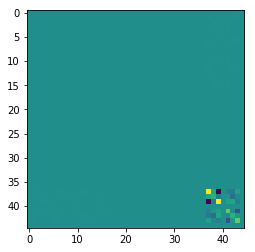

In [250]:
J = result.jac
JTJ = J.transpose().dot(J)
JTJ = 0.5 * (JTJ + JTJ.transpose())
w, u = np.linalg.eigh(JTJ)
JTJI = np.linalg.inv(JTJ)

COV = JTJI.dot(JTJI.transpose())

plt.imshow(COV)
plt.show()

In [252]:
COV

array([[ 6.50590556e+17,  1.31832199e+30, -2.53946959e+29, ...,
         3.89233886e+33,  4.74959913e+32, -3.21384682e+27],
       [ 1.31832199e+30,  1.08956550e+43, -1.91617890e+42, ...,
         4.04154536e+46,  5.95441324e+46, -2.27234766e+40],
       [-2.53946959e+29, -1.91617890e+42,  3.39464964e+41, ...,
        -7.52503397e+45, -9.70418725e+45,  3.90700538e+39],
       ...,
       [ 3.89233886e+33,  4.04154536e+46, -7.52503397e+45, ...,
         3.19351322e+50,  6.59180247e+49, -5.28978437e+43],
       [ 4.74959913e+32,  5.95441324e+46, -9.70418725e+45, ...,
         6.59180247e+49,  5.89964069e+50, -1.60717376e+44],
       [-3.21384682e+27, -2.27234766e+40,  3.90700538e+39, ...,
        -5.28978437e+43, -1.60717376e+44,  1.17940413e+38]])